In [8]:
import re
import os
import math
import pandas as pd
from os.path import join

import requests
from bs4 import BeautifulSoup

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style


In [9]:
project_folder = '/home/sandeep/Desktop/Projects/Python/India_Kanoon/'

In [10]:
# Get number of cases listed per court in IndianKanoon.org

def get_court_year_num_cases_stats():
    all_data = []
    root_url = 'https://indiankanoon.org'
    r = requests.get(root_url+'/browse/')
    soup = BeautifulSoup(r.text).find('table')
    for court_url in [root_url+x['href'] for x in soup.find_all('a')]:
        court = court_url.split('/')[-2]
        table = BeautifulSoup(requests.get(court_url).text).find_all('div', attrs= {'class':"browselist"})
        court_year_num = [(court,)+(int(re.search(r'[0-9]+', x.text)[0])
                                    , int(re.search(r'\([0-9]+\)', x.text)[0][1:-1]) ) for x in table 
                          if int(re.search(r'[0-9]+', x.text)[0]) in range(1900, 2020)]
        all_data.extend(court_year_num)
        
    return pd.DataFrame(all_data, columns = 'court year num_cases'.split())
        
        

In [11]:
# case numbers data from IK
df = get_court_year_num_cases_stats()

In [18]:
# Funtion to map heatmaps of number of cases by court and year
def num_cases_log_scale(df, recent_n_years, log_scale = False, 
                        fname = 'figure.png', save_fig=False, cbar_shrink = 0.5):
    

    from matplotlib.colors import LinearSegmentedColormap
    courts = sorted(set(df.court))
    years = sorted(set(df.year))
    l = []
    court_year_dict = dict(zip(list(zip(df.year,df.court)), list(df.num_cases)))
    for year in years[-recent_n_years:][::-1]:
        t = []
        for court in courts:
            try:
                if log_scale:
                    t.append(int(math.log(court_year_dict[(year, court)], 10)))
                else:
                    t.append(court_year_dict[(year, court)])
            except:
                if log_scale:
                    t.append(1)
                else:
                    t.append(0)
        l.append(t)
    #make discrete color paletter
    if log_scale:
        mod_colors = [[],[],[]]
        for color in sns.color_palette("Oranges", 6):
            for i, value in enumerate(color):
                m = divmod(i, 4)[-1]
                mod_colors[m].append(value) 

        fig = plt.figure(figsize=(32,recent_n_years))
        plt.xticks(rotation=90)
        myColors =  [x+(1,) for x in list(zip(*mod_colors))]
        cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))
        sns.set_context("poster", font_scale = 1)

        ax = sns.heatmap(l,xticklabels=courts, 
                         yticklabels=years[-recent_n_years:][::-1],
                         cmap=cmap,
                         cbar_kws={"shrink": cbar_shrink},
                         linewidths=1,
                         #annot=True
                        );
        colorbar = ax.collections[0].colorbar
        colorbar.set_ticks([0,1,2,3,4,5])
        colorbar.set_ticklabels([0,1,2,3,4,5])
    else:
        fig = plt.figure(figsize=(32,recent_n_years))
        plt.xticks(rotation=90)
        sns.set_context("poster", font_scale = 1)
        sns.heatmap(l,xticklabels=courts, 
                         yticklabels=years[-recent_n_years:][::-1],
                         cmap='Oranges',
                         cbar_kws={"shrink": cbar_shrink},
                         linewidths=1,
                         #annot=True
                        );

    plt.tight_layout()
    if save_fig:
        plt.savefig(fname)

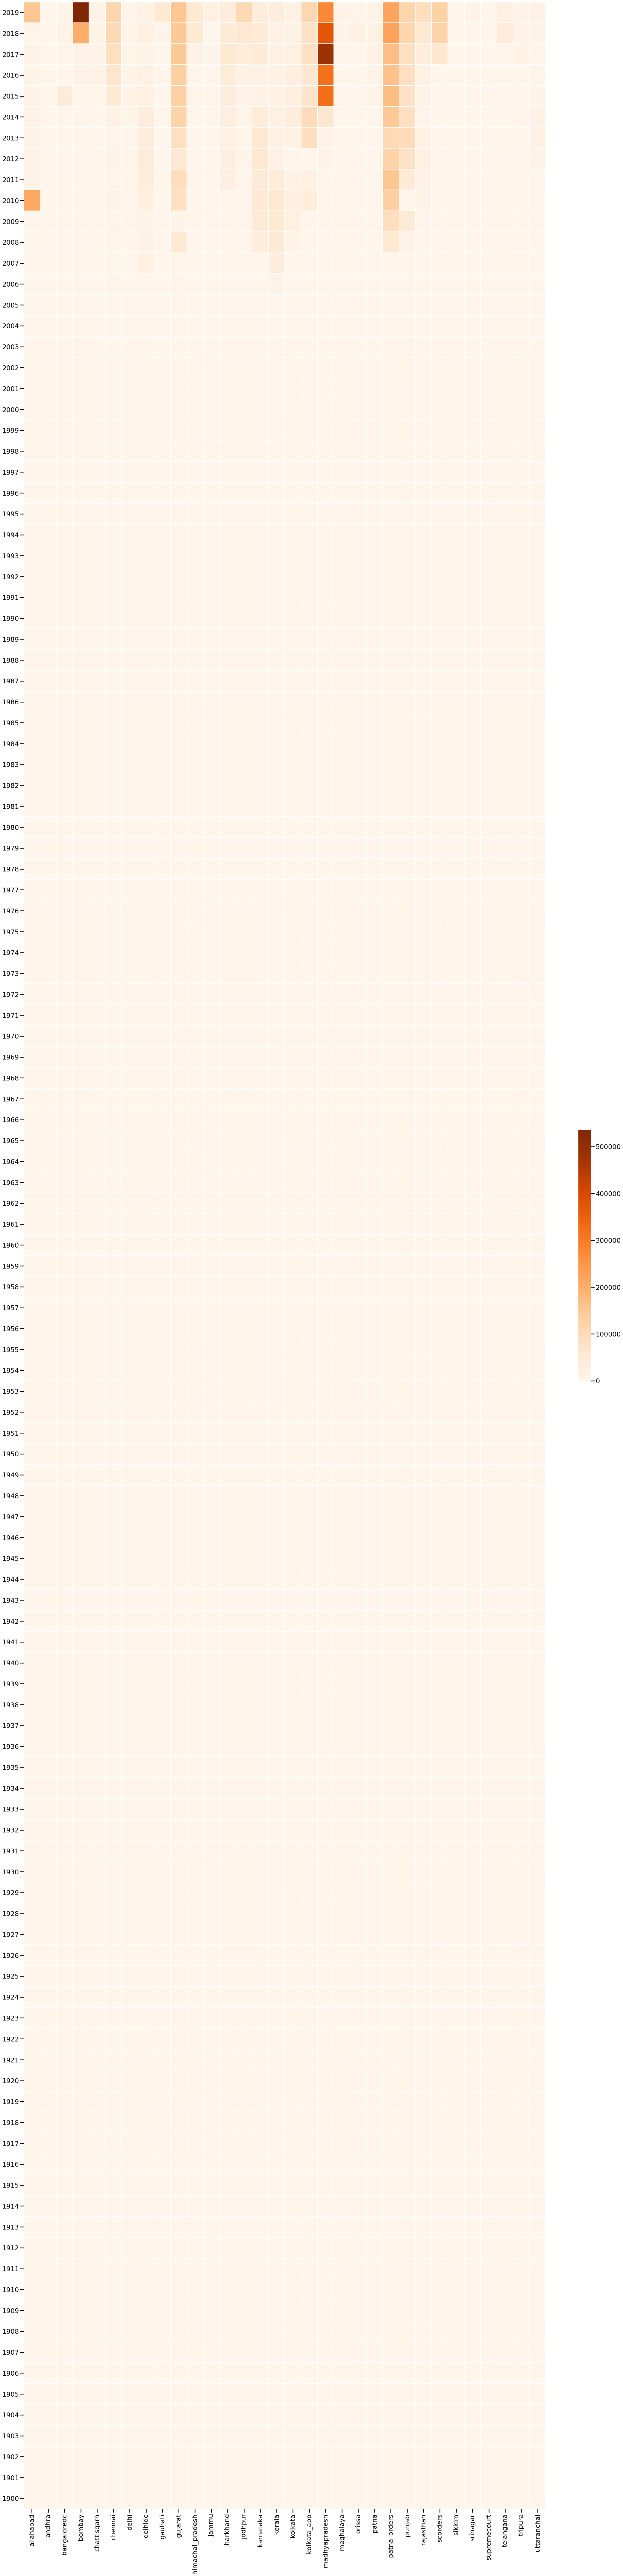

In [19]:
num_cases_log_scale(df, 120, cbar_shrink=0.1, save_fig=True, fname = 'num_cases_all.png')

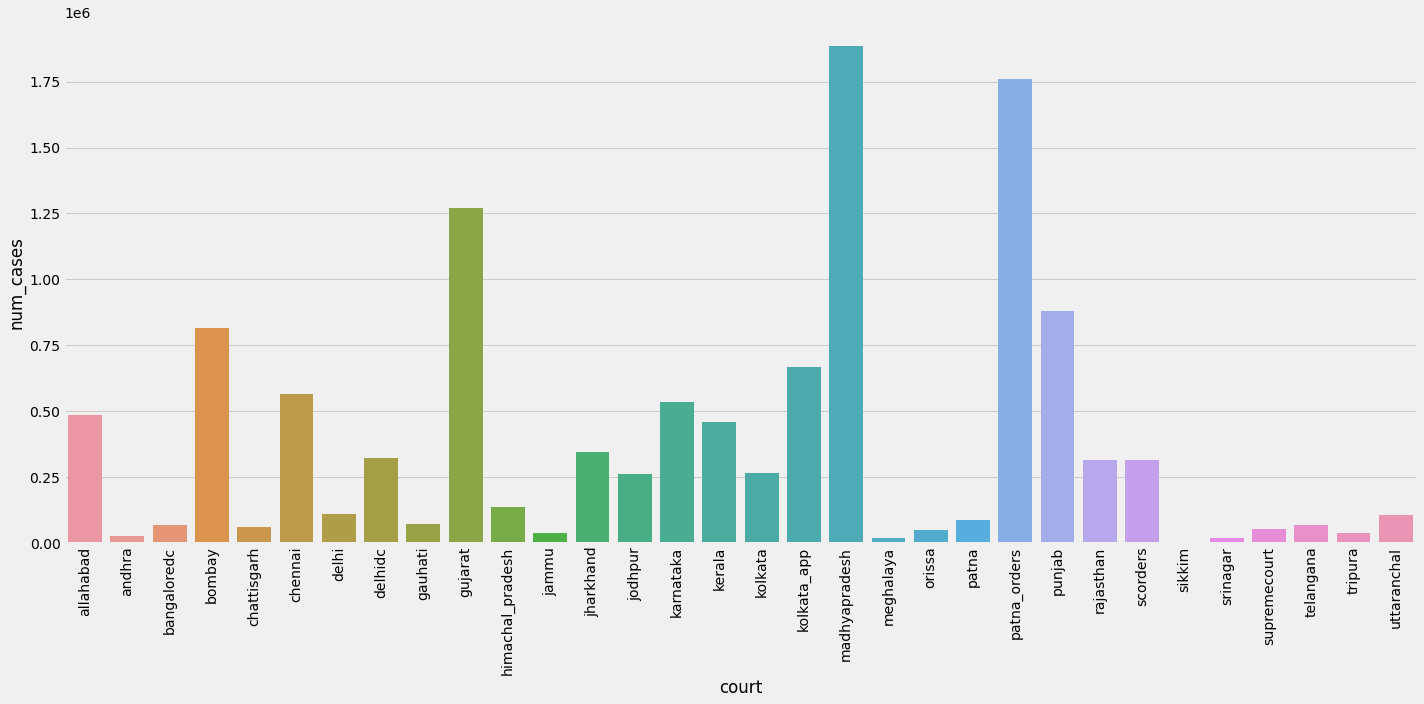

In [5]:
ddf = df.groupby('court').sum()['num_cases'].reset_index()

style.use('fivethirtyeight')
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
sns.barplot(data =ddf, x='court', y='num_cases');
plt.tight_layout()


plt.savefig('num_cases_by_court.png')


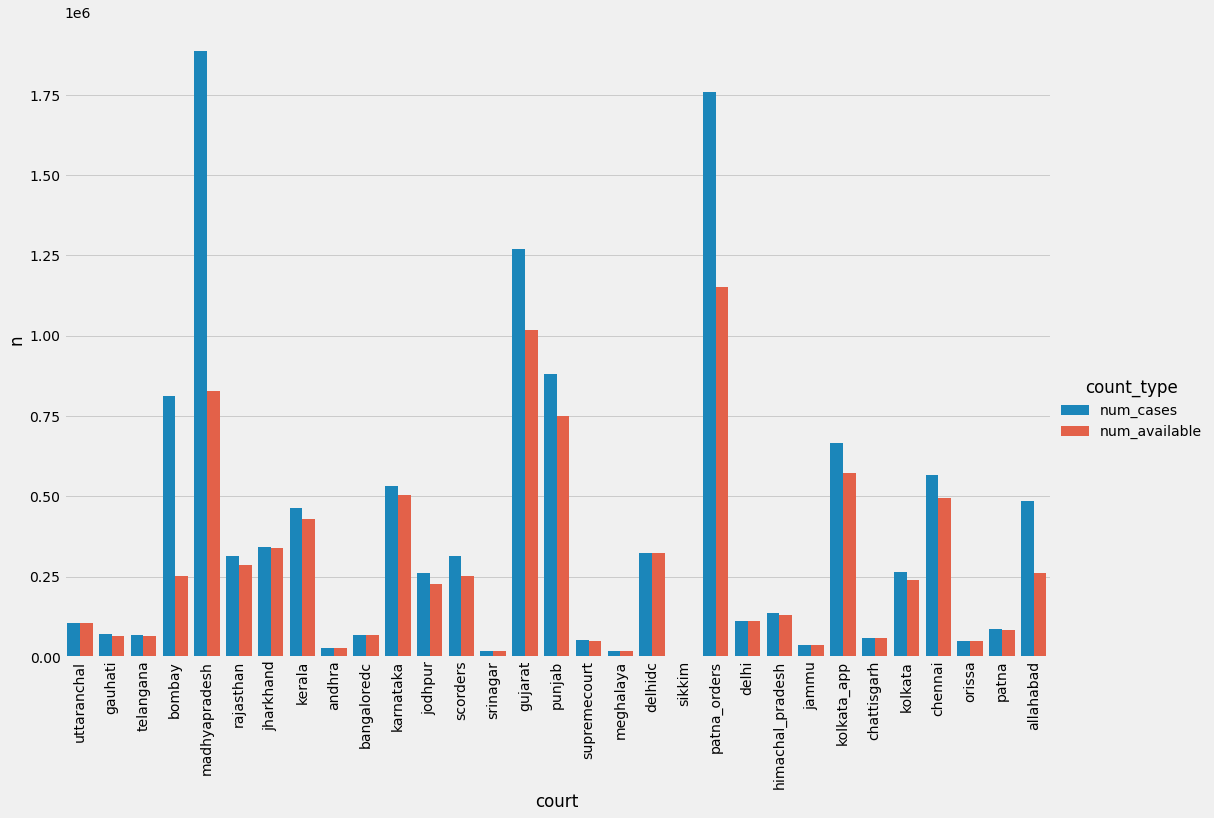

In [7]:
num_dict = {}

for item in os.listdir(join(project_folder,
                                    'data/auxillary_files/court_start_end_num_cases_num_available')):
    df_court = pd.read_csv(join(project_folder,
                                'data/auxillary_files/court_start_end_num_cases_num_available',
                                        item))
    num_dict[item.split('.')[0]] = (sum(df_court.num_cases), sum(df_court.num_available))
    
l = []
for item in num_dict:
    l.extend([(item, 'num_cases', num_dict[item][0]), (item, 'num_available', num_dict[item][1])])
df_court = pd.DataFrame(l, columns = ['court', 'count_type', 'n'])

style.use('fivethirtyeight')

chart = sns.catplot(x='court', y='n', hue='count_type', data=df_court, kind='bar',
                    height = 10, aspect=1.5);
chart.set_xticklabels(rotation=90)
chart.savefig("num_cases_vs_num_available.png")



In [12]:
num_dict

{'uttaranchal': (106596, 106497),
 'gauhati': (71241, 64174),
 'telangana': (70035, 66525),
 'bombay': (813975, 252213),
 'madhyapradesh': (1885437, 827568),
 'rajasthan': (313267, 287412),
 'jharkhand': (343603, 338097),
 'kerala': (462737, 429344),
 'andhra': (27031, 27030),
 'bangaloredc': (68532, 68212),
 'karnataka': (533625, 503911),
 'jodhpur': (262372, 227078),
 'scorders': (315445, 251001),
 'srinagar': (18540, 18473),
 'gujarat': (1269900, 1018384),
 'punjab': (879948, 750388),
 'supremecourt': (52389, 51325),
 'meghalaya': (19312, 19304),
 'delhidc': (324020, 323849),
 'sikkim': (143, 143),
 'patna_orders': (1759345, 1150722),
 'delhi': (111154, 110890),
 'himachal_pradesh': (136318, 131312),
 'jammu': (38828, 37655),
 'kolkata_app': (666227, 572598),
 'chattisgarh': (60253, 59251),
 'kolkata': (263444, 241299),
 'chennai': (565269, 495637),
 'orissa': (50940, 49712),
 'patna': (86340, 85723),
 'allahabad': (486767, 260995)}

In [41]:
def make_stacked_barplot(df, recent_n_years = 20, normalize = False, save_fig=False, fname = ''):

    style.use('fivethirtyeight')
    l = []
    court_year_dict = dict(zip(list(zip(df.year,df.court)), list(df.num_cases)))
    years = sorted(list(set([x[0] for x in court_year_dict.keys()])))
    courts = sorted(list(set([x[1] for x in court_year_dict.keys()])))
    for year in years[-recent_n_years:][::-1]:
    
        t = []
        for court in courts:
            try:
                t.append(court_year_dict[(year, court)])
            except:

                t.append(0)
        l.append(t)

    df_l = pd.DataFrame(l, columns = courts)
    df_l.index = years[-recent_n_years:][::-1]
    df_l = df_l[::-1]

    if normalize:
        df_l = df_l.div(df_l.sum(axis=0), axis=1)


    
    bar_positions = list(range(len(courts)))
    names = courts
    barWidth = 1
    colors = '#F8B195 #F67280 #C06C84 #6C5B7B #355C7D'.lower().split()

#    colors = list(matplotlib.colors.cnames.values())
#    shuffle(colors)
    

    plt.figure(figsize=(20,10))
    plt.bar(bar_positions, df_l[:1].sum().tolist(), color = colors[0], edgecolor='white', width=barWidth)
    for i in range(1, recent_n_years):
        plt.bar(bar_positions, df_l[i:i+1].sum().tolist(), bottom=df_l[:i].sum().tolist(), 
                color = colors[i], edgecolor='white', width=barWidth)

    # Custom X axis
    plt.xticks(bar_positions, names, rotation=90)
    
    plt.xlabel("courts")
    plt.ylabel("proportion of cases by year (2015 - 2019)")
    plt.tight_layout()
    
    if save_fig:        
        plt.savefig(fname)
        
    # Show graphic
    #plt.show()
    
    

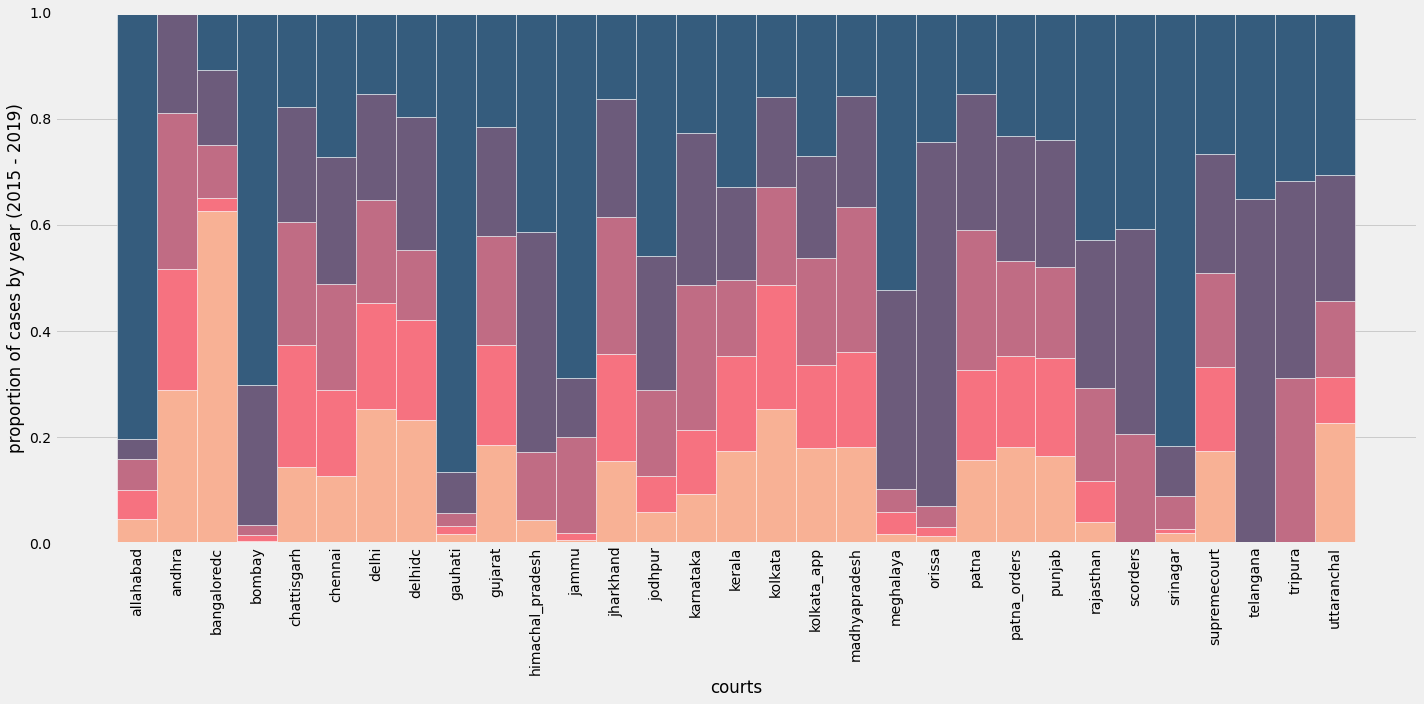

In [43]:
make_stacked_barplot(df[df.court!='sikkim'],
                     recent_n_years = 5,
                     normalize=True,
                     save_fig=True,
                     fname = 'proportion_cases_last_five_years.png')
